# Task-2:Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import sys
import os 
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.classification import accuracy_score, log_loss

from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
df_nlp = pd.read_csv("qora/nlp_features_train.csv", encoding = "latin-1") 
df_nlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [3]:
df_feat = pd.read_csv("qora/df_fe_without_preprocessing_train.csv",encoding = "latin-1")
df_feat.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [4]:
df_tot = pd.merge(df_nlp, df_feat, on = "id")
df_tot.head(2)

,id,qid1_x,qid2_x,question1_x,question2_x,is_duplicate_x,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [5]:
df = df_tot.sample(100000)
df.shape

(100000, 37)

In [6]:
y = df["is_duplicate_x"]
x = df.drop("is_duplicate_x", axis = 1)

In [7]:
train_x, test_x , train_y, test_y = train_test_split(x, y, test_size = 0.3, stratify = y)
print("Number of data points in train data :", train_x.shape)
print("Number of data points in test data :", test_x.shape)

Number of data points in train data : (70000, 36)
Number of data points in test data : (30000, 36)


In [8]:
train_x.head(2)

,id,qid1_x,qid2_x,question1_x,question2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
58303,58303,102311,86345,is homeschooling the best way of teaching our ...,what is the best way and right age to introduc...,0.399992,0.285710,0.499988,0.333328,0.444440,...,2,55,65,9,14,4.0,22.0,0.181818,3,1
24723,24723,12602,9520,if energy is created and not conserved in an e...,if more vacuum gravitational and dark energy i...,0.777769,0.636358,0.499995,0.499995,0.571426,...,16,129,138,21,23,11.0,40.0,0.275000,25,7


In [9]:
train_feats = train_x.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
train_feats.shape

(70000, 26)

In [10]:
test_x.head(2)

,id,qid1_x,qid2_x,question1_x,question2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
219745,219745,302203,326690,why are there many translations of the bible,how many words are there in the bible,0.666644,0.666644,0.599988,0.599988,0.624992,...,1,45,38,8,8,5.0,16.0,0.312500,4,2
183108,183108,280093,280094,what are some ways of doing a homemade valium,how do i do a homemade perm,0.499975,0.333322,0.249994,0.166664,0.285710,...,1,46,28,9,7,2.0,15.0,0.133333,2,0


In [11]:
test_feats = test_x.drop(["id", "is_duplicate_y", "qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x"], axis = 1)
test_feats.shape

(30000, 26)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = np.array(train_x['question1_x'].astype("unicode")) + np.array(train_x['question2_x'].astype("unicode"))
questions1 = np.array(test_x['question1_x'].astype("unicode")) + np.array(test_x['question2_x'].astype("unicode"))


tfidf = TfidfVectorizer(lowercase=False)
tfidf_train = tfidf.fit_transform(questions.astype("unicode"))
tfidf_test = tfidf.transform(questions1.astype("unicode"))


# dict key:word and value:tf-idf score
word2tfidf_train = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
word2tfidf_test = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [14]:
print(tfidf_train.shape, train_feats.shape)
print(tfidf_test.shape,train_feats.shape)

(70000, 39427) (70000, 26)
(30000, 39427) (70000, 26)


In [15]:
from scipy.sparse import hstack
x_train_tfidf = hstack([tfidf_train, train_feats], format = "csr")
x_test_tfidf = hstack([tfidf_test, test_feats], format = "csr")

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

## Train

In [18]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import en_core_web_sm
#nlp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(train_x['question1_x'].astype("unicode"))):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
train_x['q1_train_feats_m'] = list(vecs1)


100%|████████████████████████████████████| 70000/70000 [42:25<00:00, 27.49it/s]


In [20]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import en_core_web_sm
#nlp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(train_x['question2_x'].astype("unicode"))):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
train_x['q2_train_feats_m'] = list(vecs1)


100%|████████████████████████████████████| 70000/70000 [39:36<00:00, 29.46it/s]


## Test

In [21]:
vecs2 = []
for qu2 in tqdm(list(test_x['question2_x'].astype("unicode"))):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
test_x['q1_test_feats_m'] = list(vecs2)

100%|████████████████████████████████████| 30000/30000 [19:56<00:00, 25.08it/s]


In [22]:
vecs2 = []
for qu2 in tqdm(list(test_x['question2_x'].astype("unicode"))):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
test_x['q2_test_feats_m'] = list(vecs2)

100%|████████████████████████████████████| 30000/30000 [20:53<00:00, 23.93it/s]


In [23]:
nlp_meta_feats_train = train_x.drop(["qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x", "q1_train_feats_m", "q2_train_feats_m"], axis = 1)
nlp_meta_feats_train.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
58303,58303,0.399992,0.285710,0.499988,0.333328,0.444440,0.285712,0.0,0.0,5.0,...,2,55,65,9,14,4.0,22.0,0.181818,3,1
24723,24723,0.777769,0.636358,0.499995,0.499995,0.571426,0.521737,0.0,1.0,2.0,...,16,129,138,21,23,11.0,40.0,0.275000,25,7


In [24]:
nlp_meta_feats_test = test_x.drop(["qid1_x", "qid2_x", "qid1_y", "qid2_y", "question1_y", "question2_y", "question1_x", "question2_x", "q1_test_feats_m", "q2_test_feats_m"], axis = 1)
nlp_meta_feats_test.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
219745,219745,0.666644,0.666644,0.599988,0.599988,0.624992,0.624992,1.0,0.0,0.0,...,1,45,38,8,8,5.0,16.0,0.312500,4,2
183108,183108,0.499975,0.333322,0.249994,0.166664,0.285710,0.222220,0.0,0.0,2.0,...,1,46,28,9,7,2.0,15.0,0.133333,2,0


In [25]:
train_df_q1 = pd.DataFrame(train_x.q1_train_feats_m.values.tolist(), index = train_x.index)
train_df_q2 = pd.DataFrame(train_x.q2_train_feats_m.values.tolist(), index = train_x.index)
test_df_q1 = pd.DataFrame(test_x.q1_test_feats_m.values.tolist(), index = test_x.index)
test_df_q2 = pd.DataFrame(test_x.q2_test_feats_m.values.tolist(), index = test_x.index)

In [26]:
print("Number of features in nlp and preprocessed dataframe :", nlp_meta_feats_train.shape[1])
print("Number of features in train question1 w2v  dataframe :", train_df_q1.shape[1]) 

print("Number of features in train question2 w2v  dataframe :", train_df_q2.shape[1]) 

print("Number of features in final train dataframe  :", nlp_meta_feats_train.shape[1]+train_df_q1.shape[1]+train_df_q2.shape[1])

Number of features in nlp and preprocessed dataframe : 28
Number of features in train question1 w2v  dataframe : 96
Number of features in train question2 w2v  dataframe : 96
Number of features in final train dataframe  : 220


In [27]:
print("Number of features in nlp and preprocessed dataframe :", nlp_meta_feats_test.shape[1])
print("Number of features in test question1 w2v  dataframe :", test_df_q1.shape[1]) 
print("Number of features in test question2 w2v  dataframe :", test_df_q2.shape[1]) 
print("Number of features in final test dataframe  :", nlp_meta_feats_test.shape[1]+test_df_q1.shape[1]+test_df_q2.shape[1])

Number of features in nlp and preprocessed dataframe : 28
Number of features in test question1 w2v  dataframe : 96
Number of features in test question2 w2v  dataframe : 96
Number of features in final test dataframe  : 220


In [28]:
# storing the final features to csv file
if not os.path.isfile("final1_train_features.csv"):
    train_df_q1['id']=nlp_meta_feats_train['id']
    train_df_q2['id']=nlp_meta_feats_train['id']
    final_train_df = train_df_q1.merge(train_df_q2, on='id',how='left')
    result  = final_train_df.merge(nlp_meta_feats_train, on='id',how='left')
    result.to_csv("final1_train_features.csv")

In [29]:
# storing the final features to csv file
if not os.path.isfile("final1_test_features.csv"): 
    test_df_q1['id'] = nlp_meta_feats_test['id']
    test_df_q2['id'] = nlp_meta_feats_test['id']
    final_test_df = test_df_q1.merge(test_df_q2, on='id',how='left')
    result  = final_test_df.merge(nlp_meta_feats_test, on='id',how='left')
    result.to_csv("final1_test_features.csv")

In [48]:
train_df = pd.read_csv("final1_train_features.csv")
test_df = pd.read_csv("final1_test_features.csv")

In [49]:
train_df=train_df[:50000]
test_df=test_df[:30000]

In [50]:
train_df.shape

(50000, 221)

In [51]:
train_df.head()

,Unnamed: 0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,55,65,9,14,4.0,22.0,0.181818,3,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16,129,138,21,23,11.0,40.0,0.275000,25,7
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,53,48,11,10,3.0,21.0,0.142857,9,5
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,58,92,10,17,6.0,25.0,0.240000,6,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,37,49,7,9,2.0,16.0,0.125000,2,0


In [53]:
train_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [54]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(train_df.columns)
for i in cols:
    train_df[i] = train_df[i].apply(pd.to_numeric)
    print(i)

0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y
50_y
51_y
52_y
53_y
54_y
55_y
56_y
57_y
58_y
59_y
60_y
61_y
62_y
63_y
64_y
65_y
66_y
67_y
68_y
69_y
70_y
71_y
72_y
73_y
74_y
75_y
76_y
77_y
78_y
79_y
80_y
81_y
82_y
83_y
84_y
85_y
86_y
87_y
88_y
89_y
90_y
91_y
92_y
93_y
94_y
95_y
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq

In [55]:
test_df.shape

(30000, 221)

In [56]:
test_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [57]:
test_df.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,45,38,8,8,5.0,16.0,0.312500,4,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,46,28,9,7,2.0,15.0,0.133333,2,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,90,77,16,14,13.0,30.0,0.433333,3,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,44,58,8,11,3.0,19.0,0.157895,5,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,49,94,8,15,1.0,23.0,0.043478,2,0


In [58]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(test_df.columns)
for i in cols:
    test_df[i] = test_df[i].apply(pd.to_numeric)
    print(i)

0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y
50_y
51_y
52_y
53_y
54_y
55_y
56_y
57_y
58_y
59_y
60_y
61_y
62_y
63_y
64_y
65_y
66_y
67_y
68_y
69_y
70_y
71_y
72_y
73_y
74_y
75_y
76_y
77_y
78_y
79_y
80_y
81_y
82_y
83_y
84_y
85_y
86_y
87_y
88_y
89_y
90_y
91_y
92_y
93_y
94_y
95_y
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq

In [59]:
y_train = train_df["is_duplicate_y"]
X_train = train_df.drop("is_duplicate_y", axis = 1)
y_test = test_df["is_duplicate_y"]
X_test = test_df.drop("is_duplicate_y", axis = 1)

In [60]:
train_len = len(y_train)
test_len = len(y_test)

In [61]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [62]:
from collections import Counter

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.63108 Class 1:  0.36892
---------- Distribution of output variable in train data ----------
Class 0:  0.36856666666666665 Class 1:  0.36856666666666665


# random model

Log loss on Test Data using Random Model 0.887489554754507


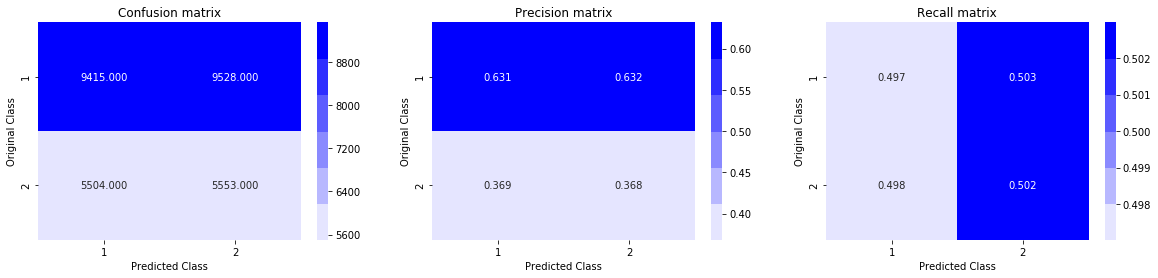

In [63]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# log reg

For values of alpha =  1e-05 The log loss is: 0.4469711228853214
For values of alpha =  0.0001 The log loss is: 0.4453606082279209
For values of alpha =  0.001 The log loss is: 0.4438348803101211
For values of alpha =  0.01 The log loss is: 0.4423560736035187
For values of alpha =  0.1 The log loss is: 0.4498856123495889
For values of alpha =  1 The log loss is: 0.48377667713307393
For values of alpha =  10 The log loss is: 0.5292161053630774


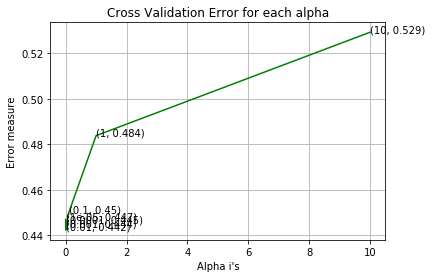

For values of best alpha =  0.01 The train log loss is: 0.4430231728689282
For values of best alpha =  0.01 The test log loss is: 0.4423560736035187
Total number of data points : 30000


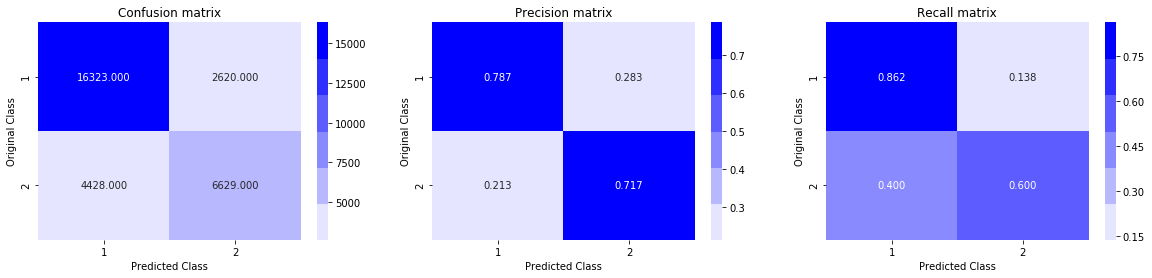

In [64]:

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# linear svm

For values of alpha =  1e-05 The log loss is: 0.45671128699584984
For values of alpha =  0.0001 The log loss is: 0.47084411804821025
For values of alpha =  0.001 The log loss is: 0.4819074322150924
For values of alpha =  0.01 The log loss is: 0.5023747580734393
For values of alpha =  0.1 The log loss is: 0.5314997900957057
For values of alpha =  1 The log loss is: 0.5270197325031946
For values of alpha =  10 The log loss is: 0.6561437436256158


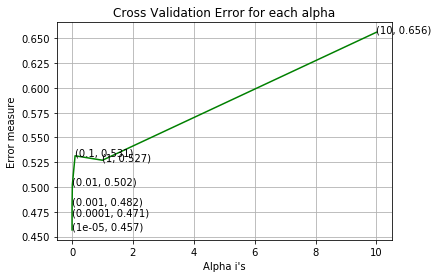

For values of best alpha =  1e-05 The train log loss is: 0.45714596493564263
For values of best alpha =  1e-05 The test log loss is: 0.45671128699584984
Total number of data points : 30000


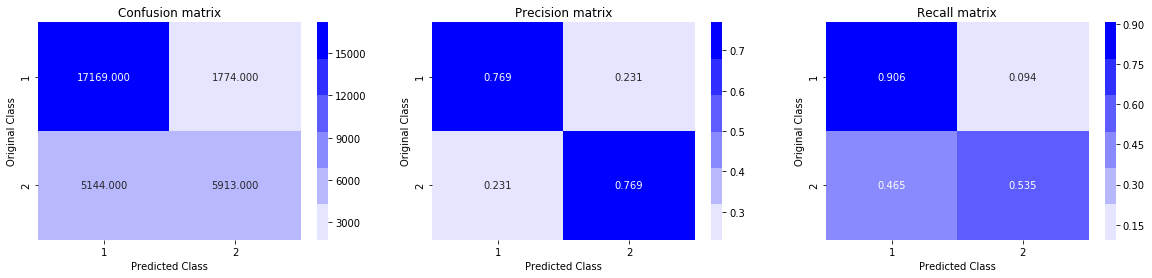

In [66]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# before hyper param gboost

In [67]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684534	valid-logloss:0.684598
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.613706	valid-logloss:0.614269
[20]	train-logloss:0.561797	valid-logloss:0.56273
[30]	train-logloss:0.523172	valid-logloss:0.524376
[40]	train-logloss:0.493582	valid-logloss:0.495113
[50]	train-logloss:0.470554	valid-logloss:0.472399
[60]	train-logloss:0.452116	valid-logloss:0.454147
[70]	train-logloss:0.437551	valid-logloss:0.43977
[80]	train-logloss:0.425624	valid-logloss:0.427988
[90]	train-logloss:0.416048	valid-logloss:0.418555
[100]	train-logloss:0.408114	valid-logloss:0.410738
[110]	train-logloss:0.401455	valid-logloss:0.404205
[120]	train-logloss:0.395761	valid-logloss:0.39865
[130]	train-logloss:0.390957	valid-logloss:0.394013
[140]	train-logloss:0.386884	valid-logloss:0.390061
[150]	train-logloss:0.383279	valid-logloss:0.386604
[160]	train-logloss:0.380353	va

Total number of data points : 30000


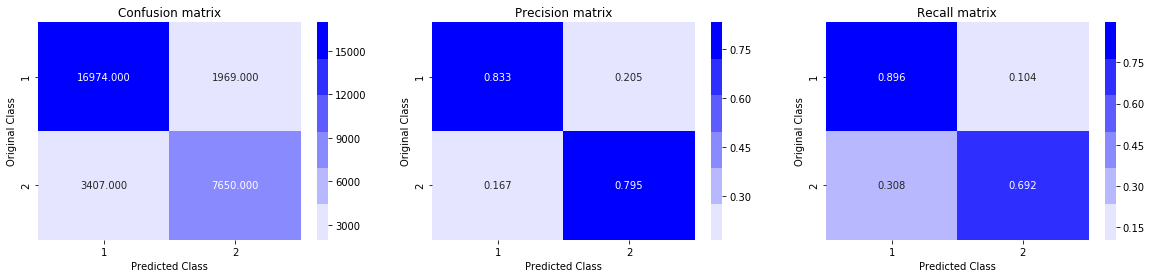

In [68]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Task-2:Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

In [69]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
# hyperparameter tuning for max_depth and min_child_weight
min_logloss = float("Inf")
best_params = None

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3, 10)
    for min_child_weight in range(1, 5)
]

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        seed=42,
        nfold=10,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,min_child_weight)   

CV with max_depth=3, min_child_weight=1
	LogLoss 0.6260298000000001 for 9 rounds
CV with max_depth=3, min_child_weight=2
	LogLoss 0.6260298000000001 for 9 rounds
CV with max_depth=3, min_child_weight=3
	LogLoss 0.6260298000000001 for 9 rounds
CV with max_depth=3, min_child_weight=4
	LogLoss 0.6260298000000001 for 9 rounds
CV with max_depth=4, min_child_weight=1
	LogLoss 0.6203107999999998 for 9 rounds
CV with max_depth=4, min_child_weight=2
	LogLoss 0.6203109 for 9 rounds
CV with max_depth=4, min_child_weight=3
	LogLoss 0.6203109 for 9 rounds
CV with max_depth=4, min_child_weight=4
	LogLoss 0.6203109999999998 for 9 rounds
CV with max_depth=5, min_child_weight=1
	LogLoss 0.6163583 for 9 rounds
CV with max_depth=5, min_child_weight=2
	LogLoss 0.6163646999999999 for 9 rounds
CV with max_depth=5, min_child_weight=3
	LogLoss 0.6163586 for 9 rounds
CV with max_depth=5, min_child_weight=4
	LogLoss 0.6163656 for 9 rounds
CV with max_depth=6, min_child_weight=1
	LogLoss 0.6133844 for 9 rounds
C

In [70]:
# best max_depth and min_child_weight
print("Best params: {}, {}".format(best_params[0], best_params[1]))

Best params: 9, 1


In [71]:
# hyperparameter tuning for subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10 for i in range(6,10)]
    for colsample in [i/10 for i in range(6,10)]
]

min_logloss = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        seed=42,
        nfold=10,
        metrics={'logloss'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample,colsample)

# Best subsample and colsample 
print("Best params: {}, {}".format(best_params[0], best_params[1]))

CV with subsample=0.9, colsample=0.9
	LogLoss 0.6091242 for 9 rounds
CV with subsample=0.9, colsample=0.8
	LogLoss 0.6097026 for 9 rounds
CV with subsample=0.9, colsample=0.7
	LogLoss 0.6107469 for 9 rounds
CV with subsample=0.9, colsample=0.6
	LogLoss 0.6124916 for 9 rounds
CV with subsample=0.8, colsample=0.9
	LogLoss 0.6092826 for 9 rounds
CV with subsample=0.8, colsample=0.8
	LogLoss 0.6099395999999999 for 9 rounds
CV with subsample=0.8, colsample=0.7
	LogLoss 0.6110914000000001 for 9 rounds
CV with subsample=0.8, colsample=0.6
	LogLoss 0.6126122 for 9 rounds
CV with subsample=0.7, colsample=0.9
	LogLoss 0.6094753 for 9 rounds
CV with subsample=0.7, colsample=0.8
	LogLoss 0.6101334000000002 for 9 rounds
CV with subsample=0.7, colsample=0.7
	LogLoss 0.6112752 for 9 rounds
CV with subsample=0.7, colsample=0.6
	LogLoss 0.6128268 for 9 rounds
CV with subsample=0.6, colsample=0.9
	LogLoss 0.6096741000000001 for 9 rounds
CV with subsample=0.6, colsample=0.8
	LogLoss 0.6102757000000001 fo

In [72]:
# hyperparameter tuning for gamma
min_logloss = float("Inf")
best_params = None

gridsearch_params=[gamma
    for gamma in [i/10.0 for i in range(0,5)]]

for gamma in gridsearch_params:
    print("CV with gamma={}".format(gamma))

    # We update our parameters
    params['gamma'] = gamma

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = gamma

# Best hyperparameter gamma 
print("Best params: {}".format(best_params))

CV with gamma=0.0
	LogLoss 0.6131045 for 9 rounds
CV with gamma=0.1
	LogLoss 0.6131015 for 9 rounds
CV with gamma=0.2
	LogLoss 0.6130943 for 9 rounds
CV with gamma=0.3
	LogLoss 0.6130924 for 9 rounds
CV with gamma=0.4
	LogLoss 0.6130879000000001 for 9 rounds
Best params: 0.4


In [73]:
# hyperparameter tuning for reg_alpha
min_logloss = float("Inf")
best_params = None


for reg_alpha in [1e-5, 1e-2, 0.1, 1, 100]:
    print("CV with reg_alpha={}".format(reg_alpha))

    # We update our parameters
    params['reg_alpha'] = reg_alpha

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = reg_alpha

# best reg_alpha        
print("Best params: {}".format(best_params))

CV with reg_alpha=1e-05
	LogLoss 0.6130879000000001 for 9 rounds
CV with reg_alpha=0.01
	LogLoss 0.6130929 for 9 rounds
CV with reg_alpha=0.1
	LogLoss 0.6131654 for 9 rounds
CV with reg_alpha=1
	LogLoss 0.6137004 for 9 rounds
CV with reg_alpha=100
	LogLoss 0.6288276999999999 for 9 rounds
Best params: 1e-05


In [74]:
# hyperparameter tuning for number of estimators
min_logloss = float("Inf")
best_params = None

for n_estimators in [80, 95, 100, 140, 175, 250, 400, 600, 700, 900]:
    print("CV with n_estimators={}".format(n_estimators))

    # We update our parameters
    params['n_estimators'] = n_estimators

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = n_estimators
# Best n_estimators
print("Best params: {}".format(best_params))

CV with n_estimators=80
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=95
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=100
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=140
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=175
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=250
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=400
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=600
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=700
	LogLoss 0.6288276999999999 for 9 rounds
CV with n_estimators=900
	LogLoss 0.6288276999999999 for 9 rounds
Best params: 80


# after hyper param of gboost

In [75]:
# Hyperparameter tuned model with best hyperparameters found using CV and reduced test log-loss.

import xgboost as xgb
params= {}

params['n_estimators'] = 80
params['min_child_weight'] = 1
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9
params['gamma'] = 0.4
params['reg_alpha'] = 1e-5
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 9

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)


xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.687915	valid-logloss:0.688104
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.640485	valid-logloss:0.642585
[20]	train-logloss:0.60104	valid-logloss:0.604948
[30]	train-logloss:0.567213	valid-logloss:0.572803
[40]	train-logloss:0.537963	valid-logloss:0.545339
[50]	train-logloss:0.512716	valid-logloss:0.521682
[60]	train-logloss:0.490651	valid-logloss:0.501233
[70]	train-logloss:0.471441	valid-logloss:0.483571
[80]	train-logloss:0.454311	valid-logloss:0.467941
[90]	train-logloss:0.439306	valid-logloss:0.454386
[100]	train-logloss:0.425676	valid-logloss:0.442262
[110]	train-logloss:0.413641	valid-logloss:0.431643
[120]	train-logloss:0.402836	valid-logloss:0.422293
[130]	train-logloss:0.393156	valid-logloss:0.413962
[140]	train-logloss:0.38448	valid-logloss:0.406641
[150]	train-logloss:0.376517	valid-logloss:0.400009
[160]	train-logloss:0.369311	v

Total number of data points : 30000


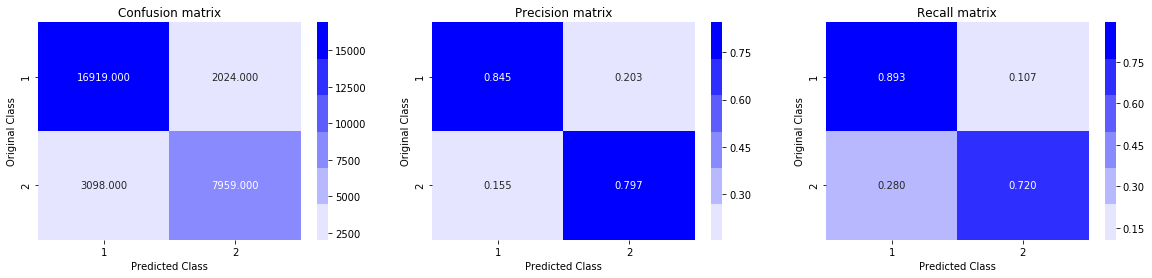

In [77]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# conclusion

* After hyperparameter tuning of Xgboost we reduced the log-loss.by picking the best hyperparamter for our xgboost model.
* for train we took 50k data points and for test we took 30k data points

In [76]:
# Please compare all your models using Prettytable library
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Table for Random Forest
name=['before hyp param of xgboost','after hyp param of gboost']

test_log_loss = [0.355,0.344]

numbering_rf = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering_rf)
ptable.add_column("Name",name)
ptable.add_column("Test log loss",test_log_loss)

print('\t\tTABLE XGBOOST')
# Printing the Table
print(ptable)
print("\n\n")


		TABLE XGBOOST
+-------+-----------------------------+---------------+
| S.NO. |             Name            | Test log loss |
+-------+-----------------------------+---------------+
|   1   | before hyp param of xgboost |     0.355     |
|   2   |  after hyp param of gboost  |     0.344     |
+-------+-----------------------------+---------------+



